In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from ydata_profiling import ProfileReport

%matplotlib inline

In [2]:
xls = pd.ExcelFile("Precios-Promedio-Nacionales-Diarios-2024-3.xlsx")

prices_data_2024 = pd.read_excel(xls, sheet_name="2024", index_col=[0], header=[0,1], skiprows=7, skipfooter=3)
prices_data_2024.columns = prices_data_2024.columns.map(' '.join)
prices_data_2024.rename_axis("Fecha").reset_index()

prices_data_2023 = pd.read_excel(xls, sheet_name="2023", index_col=[0], header=[0,1], skiprows=7, skipfooter=3)
prices_data_2023.columns = prices_data_2024.columns
prices_data_2023.rename_axis("Fecha").reset_index()

prices_data_2022 = pd.read_excel(xls, sheet_name="2022", index_col=[0], header=[0,1], skiprows=6, skipfooter=3)
prices_data_2022.columns = prices_data_2023.columns
prices_data_2022.rename_axis("Fecha").reset_index()

prices_data_2021 = pd.read_excel(xls, sheet_name="2021", index_col=[0], header=[0,1], skiprows=6, skipfooter=3)
prices_data_2021.columns = prices_data_2022.columns
prices_data_2021.rename_axis("Fecha").reset_index()

prices_data = pd.concat([prices_data_2021, prices_data_2022, prices_data_2023, prices_data_2024])
prices_data.drop(columns=["Tipo de Cambio GTQ/USD", "Bunker GTQ/GALON"], axis=1, inplace=True)

prices_report = ProfileReport(prices_data, explorative=True)
prices_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

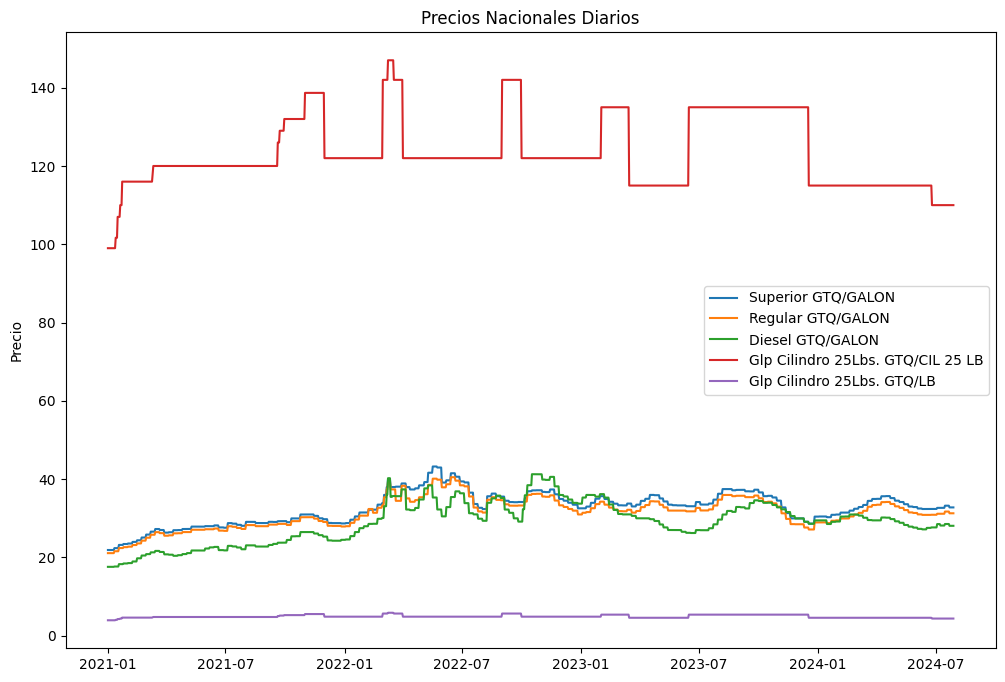

In [3]:
plt.figure(figsize=(12, 8))
for column in prices_data.columns:
    plt.plot(prices_data[column], label=f"{column}")

plt.ylabel("Precio")
plt.title(f'Precios Nacionales Diarios')
plt.legend()
plt.show()

/tmp/ipykernel_1357/1829677026.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


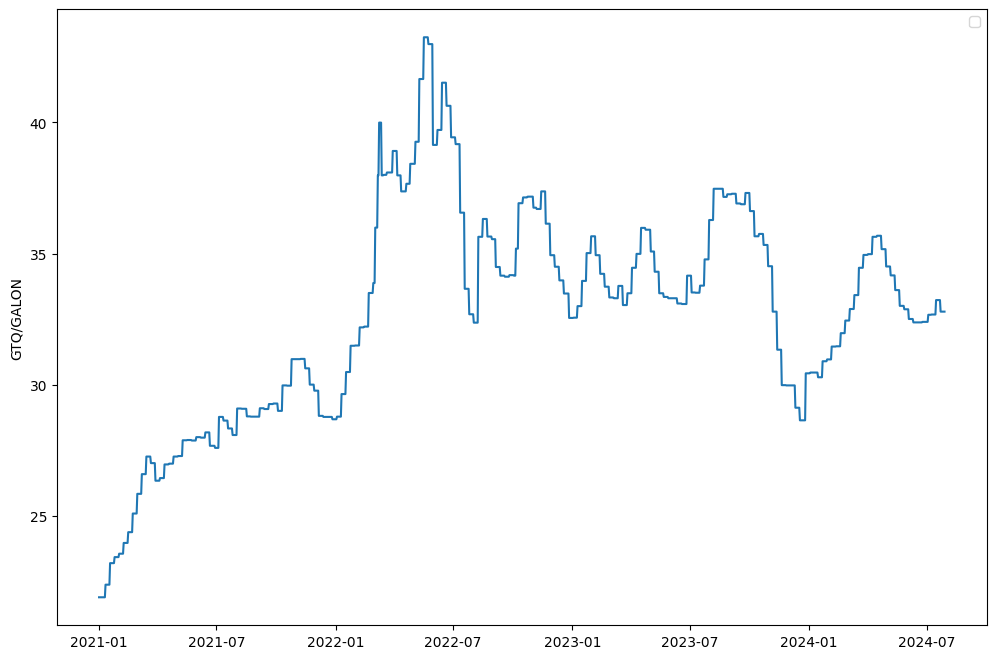

In [4]:
super_prices = prices_data["Superior GTQ/GALON"].dropna()

plt.figure(figsize=(12,8))
plt.plot(super_prices)
plt.ylabel('GTQ/GALON')
plt.legend()
plt.show()

In [5]:
inicio = min(super_prices.index)
valor = super_prices.loc[inicio]
print(f"Inicio: {inicio} | Valor: {valor}")

fin = max(super_prices.index)
valor = super_prices.loc[fin]
print(f"Final: {fin} | Valor: {valor}")

infer_freq = pd.infer_freq(super_prices.index)
print(f"Frecuencia: {infer_freq}")

Inicio: 2021-01-01 00:00:00 | Valor: 21.91
Final: 2024-07-28 00:00:00 | Valor: 32.79
Frecuencia: None


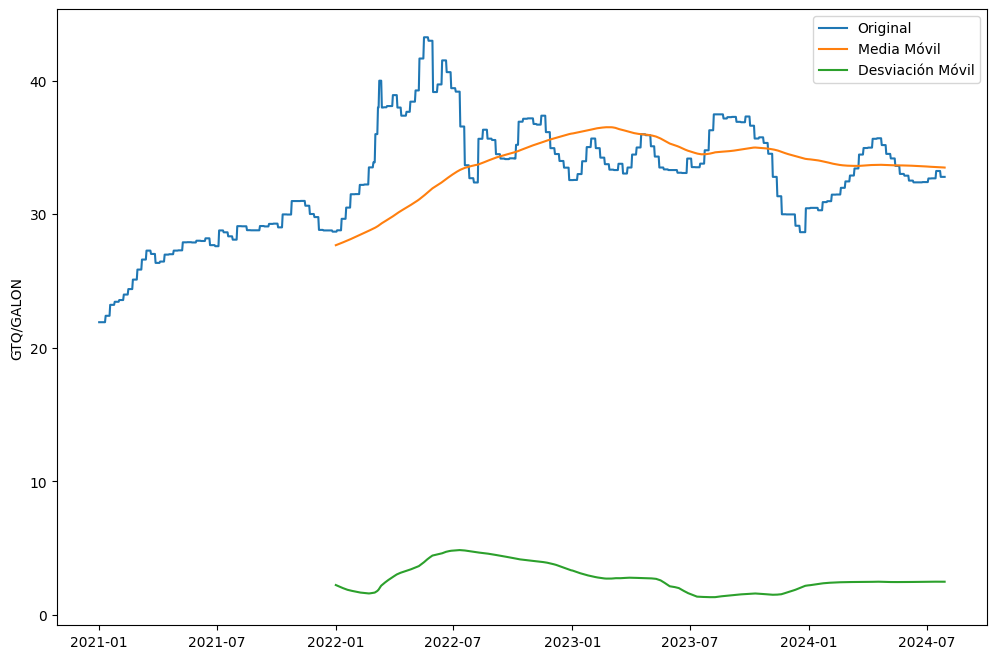

In [6]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 90 días.
mediaMovil = super_prices.rolling(window=365).mean()
deMovil = super_prices.rolling(window=365).std()


# Plot original data
plt.figure(figsize=(12, 8))
plt.plot(super_prices, label='Original')
plt.plot(mediaMovil, label='Media Móvil')
plt.plot(deMovil, label='Desviación Móvil')

plt.ylabel('GTQ/GALON')
plt.legend()
plt.show()

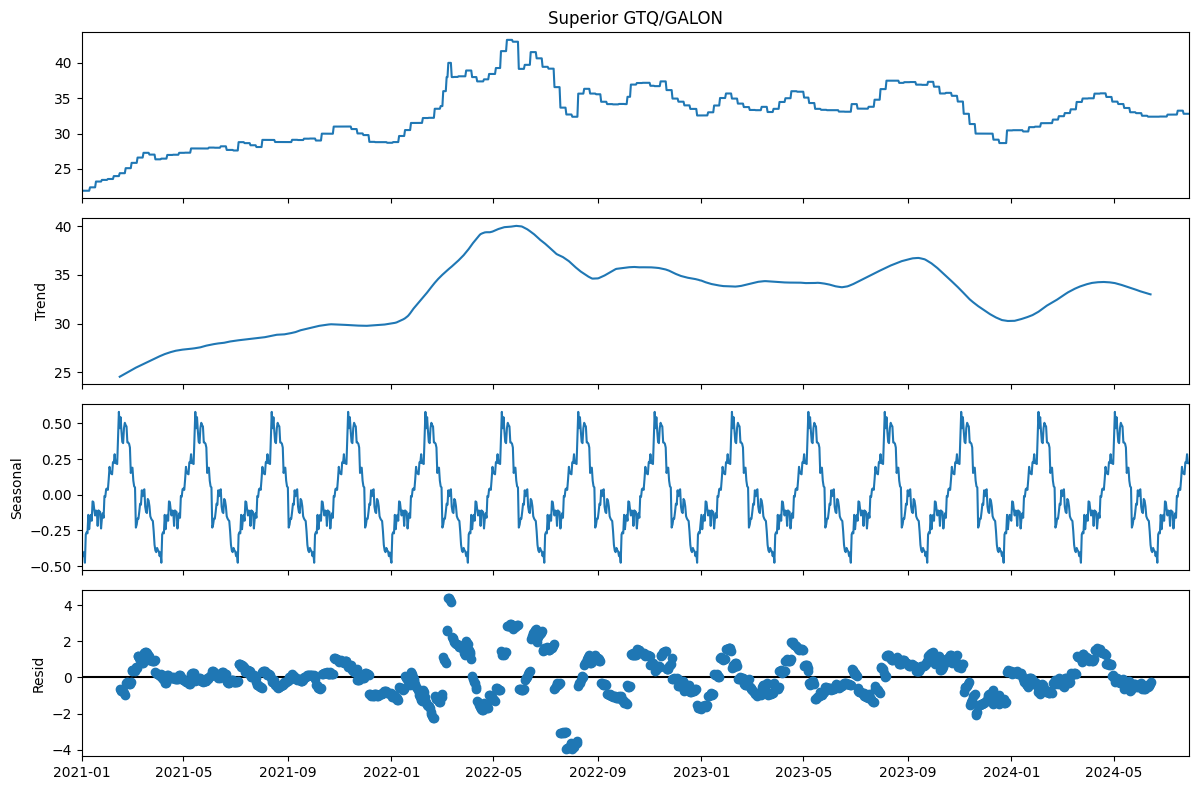

In [7]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 8))
    descomposicion = seasonal_decompose(super_prices, period=90)
    descomposicion.plot()

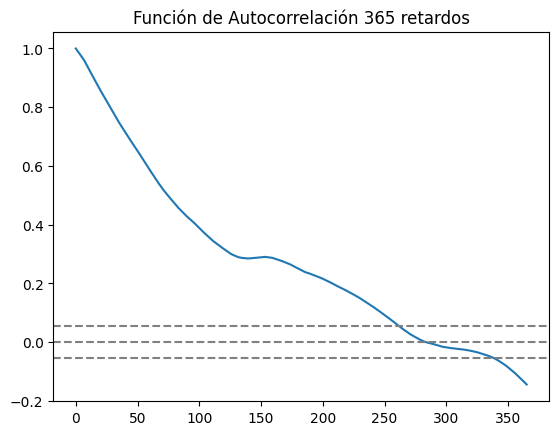

In [8]:
plt.plot(acf(super_prices, nlags=365))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación 365 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [9]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(super_prices, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          -2.938738
p-value                         0.041025
# de retardos usados            7.000000
# de observaciones usadas    1294.000000
Critical Value (1%)            -3.435414
Critical Value (5%)            -2.863776
Critical Value (10%)           -2.567961
dtype: float64


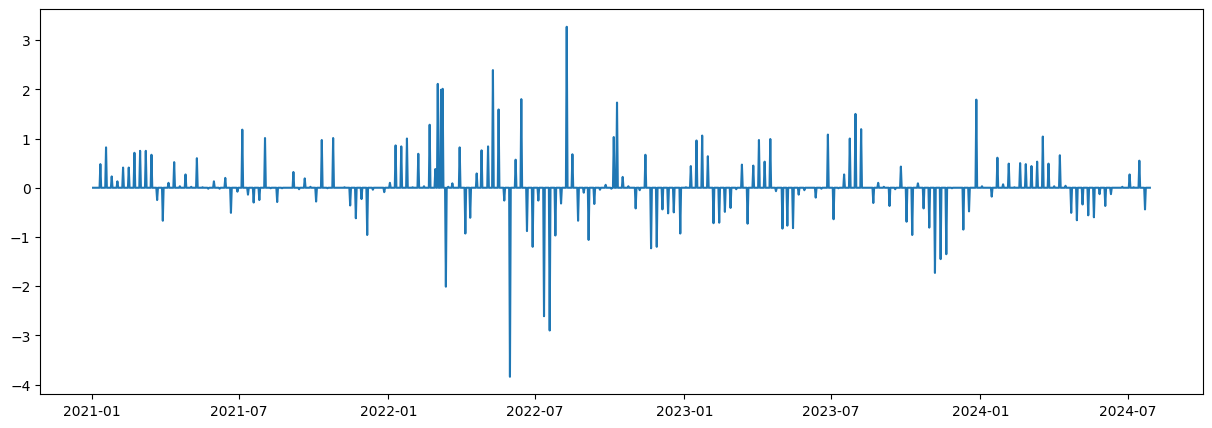

In [10]:
super_prices_diff = super_prices.diff()
super_prices_diff.dropna(inplace=True)
plt.plot(super_prices_diff)

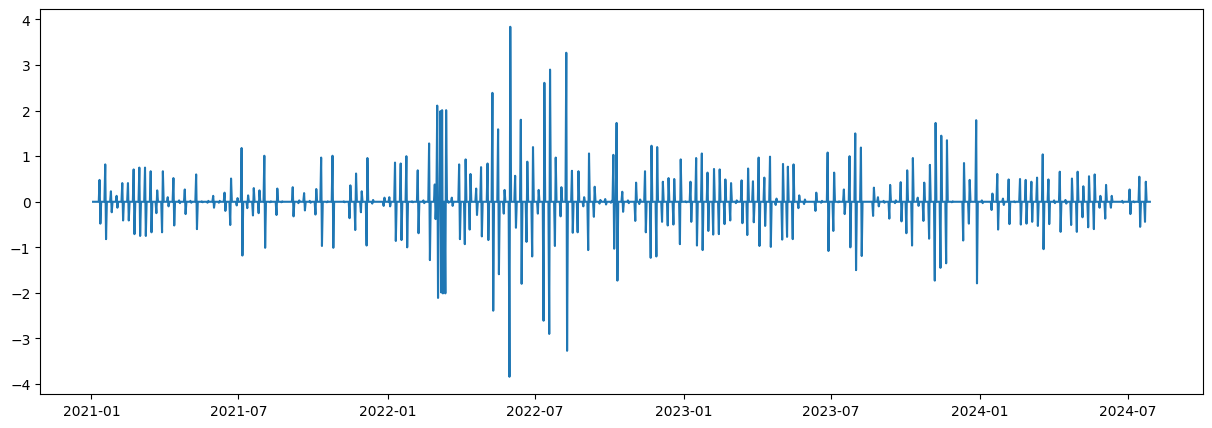

In [11]:
super_prices_diff = super_prices_diff.diff()
super_prices_diff.dropna(inplace=True)
plt.plot(super_prices_diff)

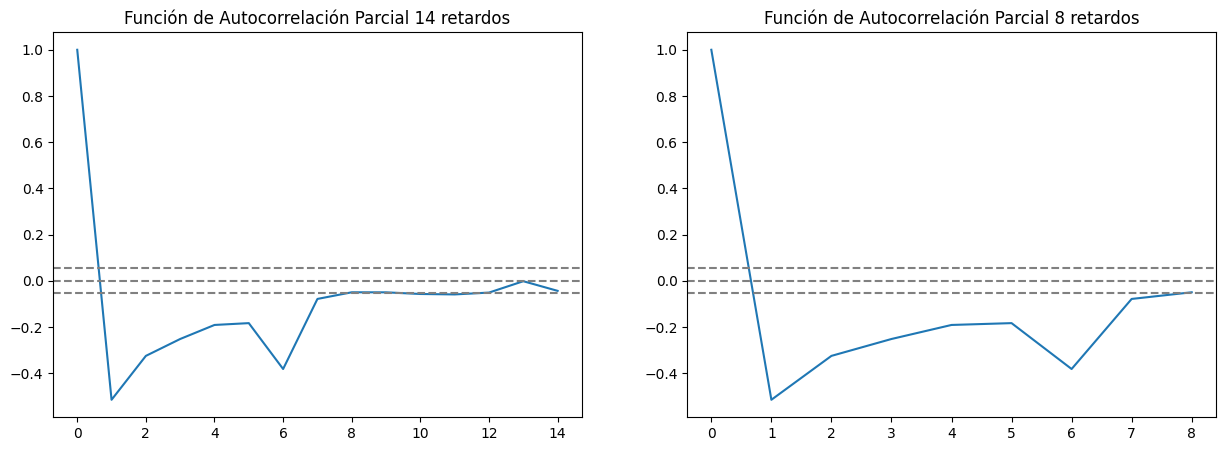

In [12]:
plt.subplot(121)
plt.plot(pacf(super_prices_diff, nlags=14))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 14 retardos')

plt.subplot(122)
plt.plot(pacf(super_prices_diff, nlags=8))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 8 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

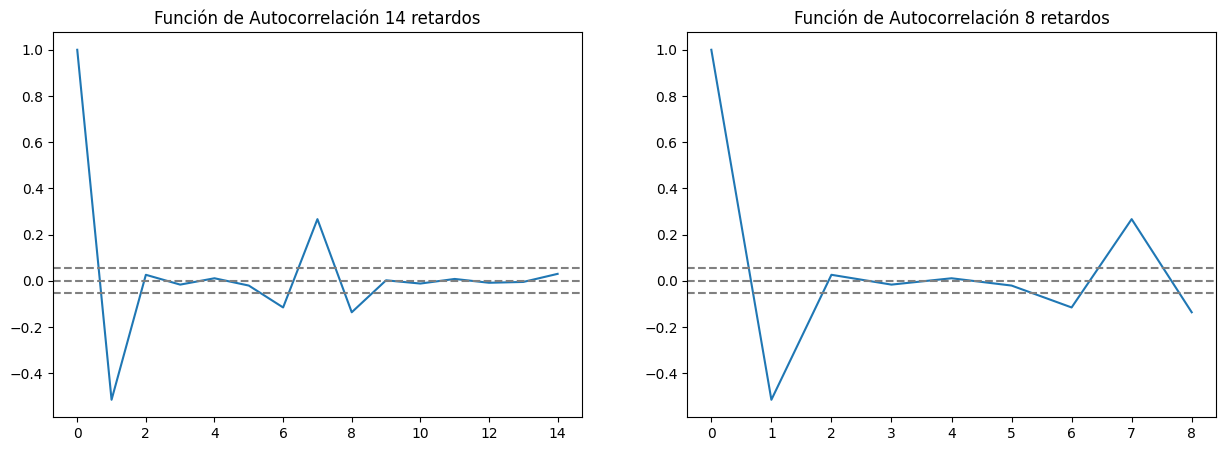

In [13]:
plt.subplot(121)
plt.plot(acf(super_prices_diff, nlags=14))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación 14 retardos')

plt.subplot(122)
plt.plot(acf(super_prices_diff, nlags=8))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación 8 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

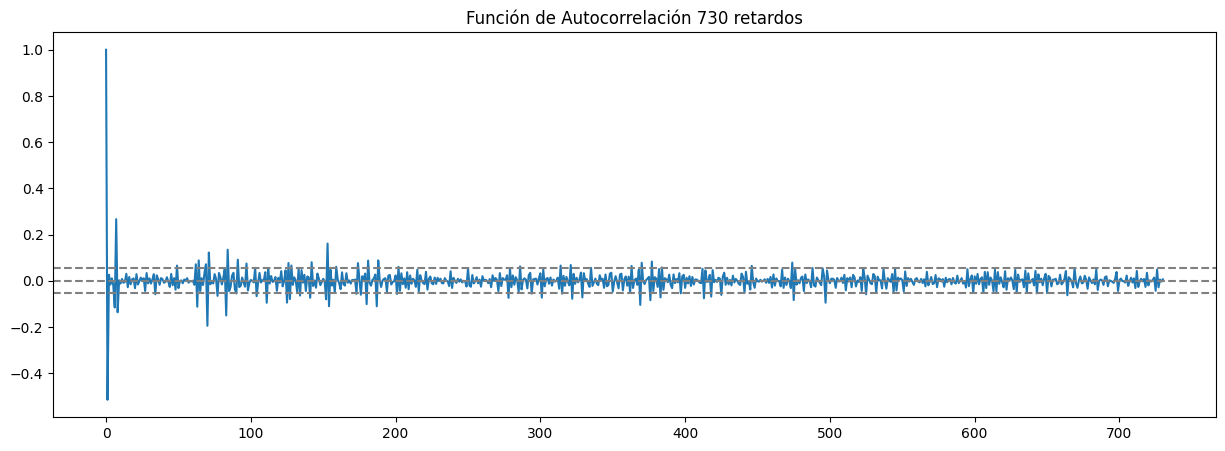

In [14]:
plt.plot(acf(super_prices_diff, nlags=730))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(super_prices)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación 730 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

P = 1 - 7  
D = 2  
Q = 1

In [15]:
super_prices_train = super_prices[:"2023-12-30"]
super_prices_test = super_prices["2024-01-01":]

In [16]:
m_results = []
for p in range(1,8):
    model = ARIMA(super_prices, order=(p, 2, 1), enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    print(f"Modelo{p}21")
    print(result.summary().tables[1])
    m_results.append(result)

/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Modelo121
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -8.507e-06      0.093  -9.11e-05      1.000      -0.183       0.183
ma.L1         -0.9975      0.003   -363.542      0.000      -1.003      -0.992
sigma2         0.1063      0.001    110.459      0.000       0.104       0.108


/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Modelo221
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0019      0.227     -0.008      0.993      -0.447       0.443
ar.L2          0.0270      0.029      0.940      0.347      -0.029       0.083
ma.L1         -1.0024      0.003   -347.041      0.000      -1.008      -0.997
sigma2         0.1058      0.001    112.018      0.000       0.104       0.108


/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Modelo321
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0019      0.229     -0.008      0.993      -0.451       0.447
ar.L2          0.0267      0.029      0.922      0.356      -0.030       0.083
ar.L3         -0.0012      0.123     -0.010      0.992      -0.242       0.240
ma.L1         -0.9977      0.003   -346.850      0.000      -1.003      -0.992
sigma2         0.1063      0.001    103.231      0.000       0.104       0.108


/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Max

Modelo421
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0021      0.238     -0.009      0.993      -0.469       0.465
ar.L2          0.0272      0.029      0.940      0.347      -0.030       0.084
ar.L3       3.211e-06      0.091   3.54e-05      1.000      -0.178       0.178
ar.L4      -2.777e-06      0.018     -0.000      1.000      -0.035       0.035
ma.L1         -0.9977      0.003   -341.626      0.000      -1.003      -0.992
sigma2         0.1064      0.001    104.290      0.000       0.104       0.108
Modelo521
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0020      0.258     -0.008      0.994      -0.507       0.503
ar.L2          0.0269      0.029      0.924      0.356      -0.030       0.084
ar.L3          0.0036      0.129

/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Modelo621
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6850      0.069     -9.988      0.000      -0.819      -0.551
ar.L2         -0.5949      0.061     -9.713      0.000      -0.715      -0.475
ar.L3         -0.5406      0.055     -9.826      0.000      -0.648      -0.433
ar.L4         -0.4705      0.046    -10.215      0.000      -0.561      -0.380
ar.L5         -0.4218      0.022    -19.019      0.000      -0.465      -0.378
ar.L6         -0.3338      0.014    -24.592      0.000      -0.360      -0.307
ma.L1         -0.2680      0.078     -3.448      0.001      -0.420      -0.116
sigma2         0.1042      0.001    111.764      0.000       0.102       0.106


/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Modelo721
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0080      0.076     -0.106      0.916      -0.157       0.141
ar.L2          0.0279      0.037      0.750      0.453      -0.045       0.101
ar.L3          0.0013      0.059      0.022      0.983      -0.115       0.118
ar.L4          0.0106      0.021      0.509      0.611      -0.030       0.052
ar.L5         -0.0086      0.105     -0.082      0.935      -0.214       0.197
ar.L6          0.0257      0.026      0.996      0.319      -0.025       0.076
ar.L7          0.2839      0.009     30.097      0.000       0.265       0.302
ma.L1         -1.0000      2.531     -0.395      0.693      -5.960       3.960
sigma2         0.0979      0.248      0.395      0.693      -0.388       0.584


In [17]:
print("Resultados de AIC (Akaike information criterion)")
for i, result in enumerate(m_results):
    print(f"Modelo {i+1}21=",result.aic)
    
print("Resultados de BIC (Bayesian information criterion)")
for i, result in enumerate(m_results):
    print(f"Modelo {i+1}21=",result.bic)

Resultados de AIC (Akaike information criterion)
Modelo 121= 784.7507604953645
Modelo 221= 786.8822885735415
Modelo 321= 788.5715569059889
Modelo 421= 790.5955142864202
Modelo 521= 793.1351465313045
Modelo 621= 762.1192235155396
Modelo 721= 689.7056583381668
Resultados de BIC (Bayesian information criterion)
Modelo 121= 800.2565001871566
Modelo 221= 807.5566081625976
Modelo 321= 814.4106028275711
Modelo 421= 821.5977415478935
Modelo 521= 829.29900835024
Modelo 621= 803.4431713160263
Modelo 721= 736.1881417471135


In [18]:
result_m721 = m_results[6]

In [19]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [20]:
m = Prophet()

newData = super_prices.reset_index()

# Create a DataFrame from the two Series
dataframe = pd.DataFrame({
    'ds': newData['index'],
    'y': newData['Superior GTQ/GALON']
})

m.fit(dataframe)

23:03:05 - cmdstanpy - INFO - Chain [1] start processing
23:03:06 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1302,2024-07-29,32.024130,30.932477,33.124974
1303,2024-07-30,32.051426,30.893543,33.208388
1304,2024-07-31,32.142751,31.068754,33.238240
1305,2024-08-01,32.233221,31.087267,33.423130
1306,2024-08-02,32.315835,31.141323,33.446977
1307,2024-08-03,32.402979,31.276495,33.559601
1308,2024-08-04,32.471728,31.399731,33.703432
1309,2024-08-05,32.617951,31.528442,33.766388
1310,2024-08-06,32.677808,31.498120,33.767802
1311,2024-08-07,32.791294,31.742074,33.954860


/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


(19723.0, 19932.0)

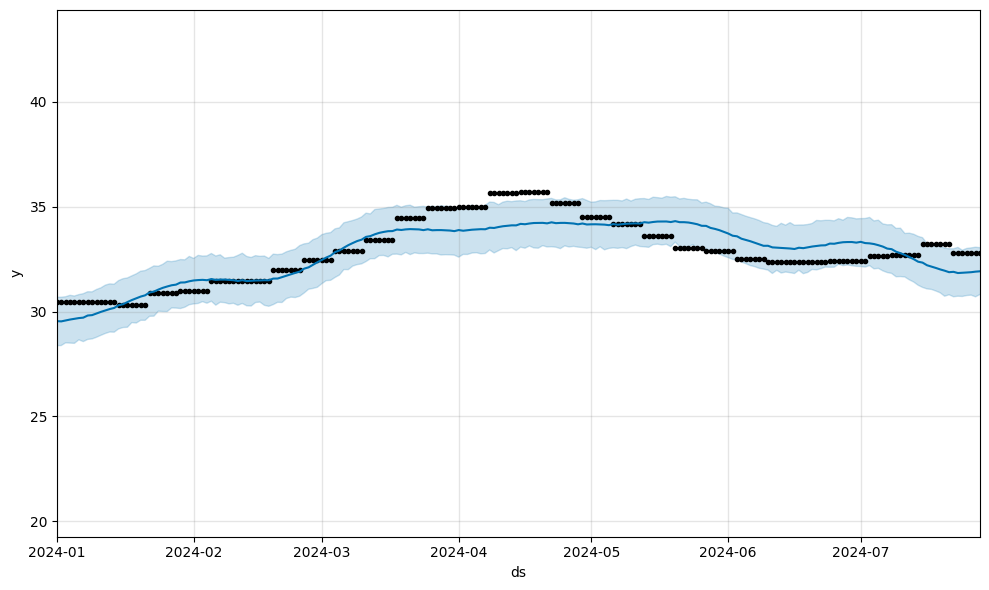

In [22]:
fig1 = m.plot(forecast)

ax = fig1.gca()
# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2024-01-01', '2024-07-28']))

/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/darielvr/Escritorio/Data/Laboratorio2/.venv/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will re

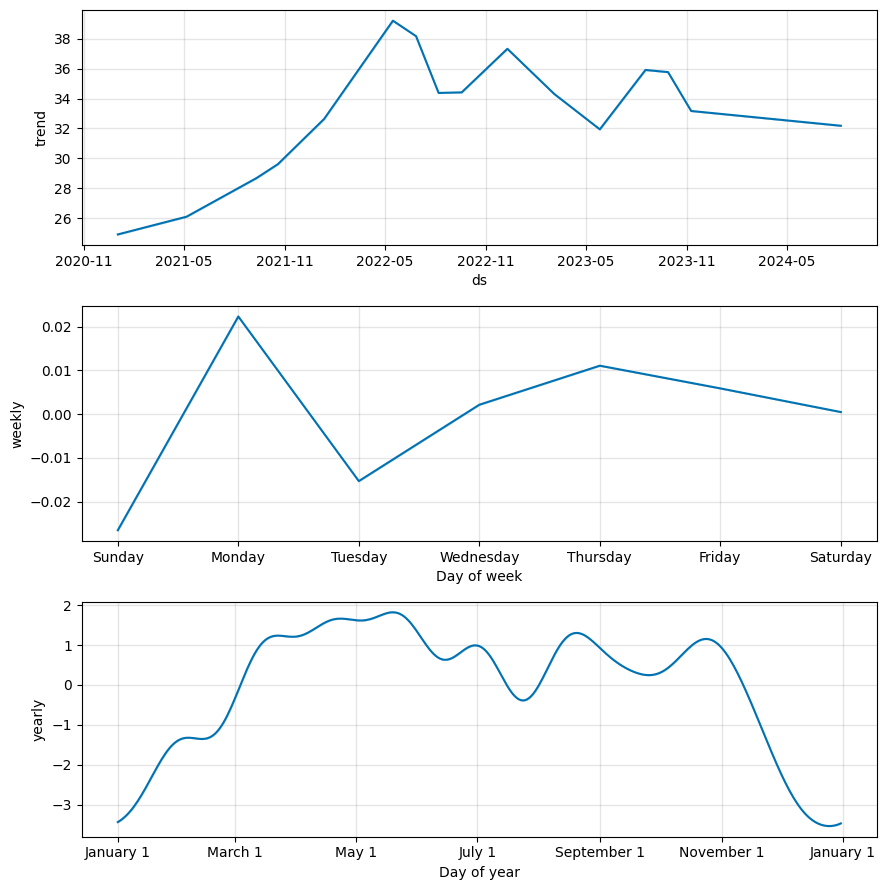

In [23]:
fig2 = m.plot_components(forecast)

In [24]:
super_prices_test.index[0]

Timestamp('2024-01-01 00:00:00')

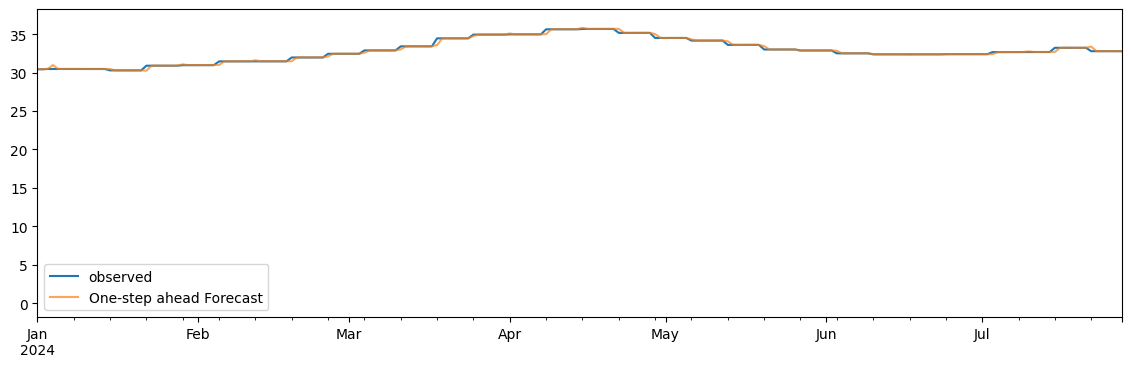

In [27]:
pred = result_m721.get_prediction(start=super_prices_test.index[0], dynamic=False)
pred_ci = pred.conf_int()
ax = super_prices['2024':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
plt.legend()
plt.show()

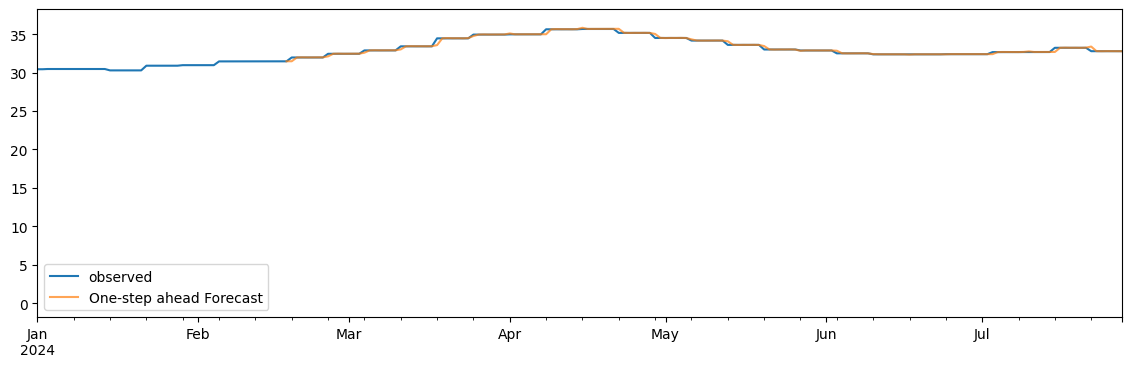

In [31]:
pred = result_m721.get_prediction(start=super_prices_test.index[48], dynamic=False)
pred_ci = pred.conf_int()
ax = super_prices['2024-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)

plt.legend()
plt.show()

pred